In [1]:
# install dependencies
!pip install padl
!git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch.git
!pip install -r v-diffusion-pytorch/requirements.txt

fatal: destination path 'v-diffusion-pytorch' already exists and is not an empty directory.


In [2]:
# download the diffusion model checkpoint model
!curl https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1_cfg.pth --output cc12m_1_cfg.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0^C


In [1]:
import sys
sys.path.append('v-diffusion-pytorch')
sys.path.append('v-diffusion-pytorch/CLIP')

In [2]:
# import dependencies
import os
import subprocess

from functools import partial
from pathlib import Path

import cv2

import math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import trange, tqdm
from clip import clip, tokenize

from diffusion import get_model, get_models, sampling, utils
from diffusion.sampling import plms_sample
from diffusion.models.cc12m_1 import CC12M1Model

import padl

transforms = padl.transform(transforms)
F = padl.transform(F)
CC12M1Model = padl.transform(CC12M1Model)

In [3]:
IMAGE_FOLDER = 'generated_images'
DEVICE = 'cuda:0'
BATCH_SIZE = 4
HEIGHT = 256
WIDTH = 256 + 64

In [5]:
# load models
diffusion_model = CC12M1Model()
diffusion_model.load_state_dict(torch.load('cc12m_1_cfg.pth'))
clip_model = padl.transform(clip.load('ViT-B/16', jit=False)[0])

In [6]:
# utils
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

@padl.transform
class Resize:
    def __init__(self, width, height):
        self.width = width
        self.height = height
    
    def __call__(self, image):
        fac = max(self.width / image.size[0], self.height / image.size[1])
        return image.resize((int(fac * image.size[0]), int(fac * image.size[1])), Image.LANCZOS)


@padl.transform
def load_image(path):
    return Image.open(path).convert('RGB')


@padl.transform
def unpack(x):
    if isinstance(x, tuple):
        if len(x) == 0:
            return x
        return unpack(x[0]) + unpack(x[1:])
    else:
        return x,


@padl.transform
def pil_image_to_tensor(x):
    """Converts from a PIL image to a tensor."""
    x = TF.to_tensor(x)
    if x.ndim == 2:
        x = x[..., None]
    return x * 2 - 1

def Preprocess(width, height, pad):
    return (
        transforms.Pad(pad)
        >> Resize(width, height)
        >> transforms.CenterCrop((width, height))
        >> pil_image_to_tensor
        >> padl.same.to(DEVICE)
    )

def ImageLoader(width, height, pad):
    return (
        load_image
        >> Preprocess(width, height, pad)
    )

@padl.transform
def display_images(images):
    fig = plt.figure(0, figsize=(20,20))
    for ix, im in enumerate(images):
        ax = fig.add_subplot(2, len(images) // 2, ix+1)
        ax.imshow(im)
        ax.axis('off')
    return fig

In [24]:
# utils for generating the face-mask

@padl.transform
def ellipse(im, box_coords):
    x, y, w, h = tuple(box_coords)
    center = ((x + w // 2), (y + h // 2))
    return cv2.ellipse(im.copy(), center, (int(h // 2 * 1.3), w // 2), 90, 0, 360, 1, -1)


@padl.transform
def grey(im_array):
    return cv2.cvtColor(im_array, cv2.COLOR_BGR2GRAY)


@padl.transform
def torch_im_to_numpy(im):
    return im.cpu().permute(0,1,2).numpy()


@padl.transform
def torch_im_to_pil(im):
    return utils.to_pil_image(im)


@padl.transform
class FaceDetect:
    def __init__(self):
        self.cc = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    def __call__(self, grey_image):
        return self.cc.detectMultiScale(grey_image)[:1]

    
@padl.transform
def add_batch_dim(im):
    return im.repeat(BATCH_SIZE, 3, 1, 1)


@padl.transform
def smoothen(im):
    kernel = np.ones((30,30), np.float32) / 25
    res = cv2.filter2D(im, -1, kernel)
    res /= res.max()
    res -= res.min()
    return res
    
    
facedetect_torch = (
    torch_im_to_pil
    >> padl.transform(np.array)
    >> grey
    >> FaceDetect()
)

facedetect_mask = (
    facedetect_torch
    >> ~ padl.transform(lambda x: ellipse(np.zeros((WIDTH, HEIGHT)), x))
    >> padl.transform(lambda x: sum(x))
    >> smoothen
    >> padl.transform(lambda x: torch.tensor(x, dtype=torch.float32).to(DEVICE))
    >> add_batch_dim
)


def t_to_alpha_sigma(t, wave_length=2):
    """Returns the scaling factors for the clean image and for the noise, given
    a timestep."""
    return torch.cos(t * math.pi/wave_length), torch.sin(t * math.pi/wave_length)

In [25]:
# clip-embedding pipelines

embed_text = (
    padl.transform(tokenize)
    >> padl.same.to(DEVICE)
    >> padl.transform(clip_model.encode_text)
)

embed_prompts = (
    ~ embed_text
)

embed_image = (
    Preprocess(WIDTH, HEIGHT, 0)
    >> normalize
    >> padl.batch
    >> padl.transform(clip_model.encode_image)
    >> padl.same.float()
    >> padl.transform(lambda x: F.normalize(x, dim=-1))
)

embed_images = (
    ~ embed_image
)

embed_images = embed_images.pd_to(DEVICE)


In [26]:
# sampling

@padl.transform
class CFGModel(torch.nn.Module):
    def __init__(self, model, target_embeddings, weights):
        super().__init__()
        self.model = model
        self.target_embeddings = target_embeddings
        self.weights = weights
    
    def forward(self, x, t):
        n = x.shape[0]
        n_conds = len(self.target_embeddings)
        x_in = x.repeat([n_conds, 1, 1, 1])
        t_in = t.repeat([n_conds])
        clip_embed_in = torch.cat([*self.target_embeddings]).repeat_interleave(n, 0)
        vs = self.model(x_in, t_in, clip_embed_in).view([n_conds, n, *x.shape[1:]])
        v = vs.mul(self.weights[:, None, None, None, None]).sum(0)
        return v

    
def make_model(text_prompts, image_prompts):
    if text_prompts is None:
        text_prompts = {}

    if image_prompts is None:
        image_prompts = {}

    target_embeddings = (
        torch.zeros([1, clip_model.visual.output_dim], device=DEVICE),
        *list(embed_prompts(text_prompts) + embed_images.infer_apply([x[0] for x in image_prompts]))
    )
    weights =  list(text_prompts.values()) + list([x[1] for x in image_prompts])
    weights = 1 - sum(weights), *weights
    weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
    return CFGModel(diffusion_model, target_embeddings, weights).pd_to(DEVICE)


@padl.transform
class Sampler:
    """Draws samples from a model given starting noise.

        :param model: Diffusion model
        :param x: input
        :param steps: List of stepsizes
        :param eta: Amount of noise added every step
        :param extra_args: args for model
        :param target_img: Target Image to match to
        :param mask: Mask to mask the target image
        :param resample_step: Number of re-runs of resampling
        :param resample_frequecy: How often to run resampling
        :param stop_mask_step_size: Step when to stop masking
    """
    def __init__(self, 
                 eta=0, 
                 sample_steps=50,
                 n_resample_steps=10,
                 resample_frequency=4,
                 resample_fresh_noise=0.5,
                 resample_stop_timestep=0,
                 unmask_timestep=0,
                 starting_timestep=1.,
                 schedule_wave_length=2.,  # TODO: ?
                 shape=(256,256)):
        
        self.eta = eta
        self.sample_steps = sample_steps
        
        self.n_resample_steps = n_resample_steps
        self.resample_frequency = resample_frequency
        self.resample_fresh_noise = resample_fresh_noise
        self.resample_stop_timestep = resample_stop_timestep
        
        self.starting_timestep = starting_timestep
        
        self.unmask_timestep = unmask_timestep
        
        self.t = torch.linspace(1, 0, sample_steps + 1, device=DEVICE)[:-1]
        steps = utils.get_spliced_ddpm_cosine_schedule(self.t)
        self.steps = steps[steps < starting_timestep]
        
        self.schedule_wave_length = schedule_wave_length
        self.alphas, self.sigmas = t_to_alpha_sigma(self.steps, wave_length=schedule_wave_length)
        
        self.shape = shape

    def __call__(self, target_image, mask, text_prompts=None, image_prompts=None):
        """Call (forward) of Sampler"""
        
        alphas, sigmas = self.alphas, self.sigmas
        
        cfg_model = make_model(text_prompts, image_prompts)
        
        x = torch.randn([BATCH_SIZE, 3, self.shape[0], self.shape[1]], device=DEVICE)
        ts = x.new_ones([x.shape[0]])
        
        init = target_image[None].repeat([BATCH_SIZE, 1, 1, 1]).to(DEVICE)
        x = init * alphas[0] + x * sigmas[0]

        preds = []

        pbar = trange(len(self.steps), disable=None)

        for step_ind in pbar:
            
            if self.steps[step_ind] < self.unmask_timestep:
                mask = None

            if mask is None:
                n_resample_steps = 1
            elif step_ind % self.resample_frequency != 1:
                n_resample_steps = 1
            elif step_ind == len(self.steps) - 1:
                n_resample_steps = 1
            elif self.steps[step_ind] < self.resample_stop_timestep:
                n_resample_steps = 1
            else:
                n_resample_steps = self.n_resample_steps

            for resample_step in range(n_resample_steps):
                mask_none = mask is None
                pbar.set_description(f'step: {step_ind}; resampling: {resample_step}/{n_resample_steps}; mask none: {mask_none}')

                with torch.cuda.amp.autocast():
                    v = cfg_model.infer_apply((x, ts * self.steps[step_ind])).float()

                # Predict the noise and the denoised image
                pred = x * alphas[step_ind] - v * sigmas[step_ind]
                eps = x * sigmas[step_ind] + v * alphas[step_ind]

                preds.append((resample_step, pred))

                # If we are in last step, stop here
                if step_ind == len(self.steps) - 1:
                    break

                if resample_step < n_resample_steps - 1:
                    # If resampling is continuing, readd noise and go again
                    
                    noise = (
                        math.sqrt(self.resample_fresh_noise) * torch.randn_like(x) 
                        + math.sqrt(1 - self.resample_fresh_noise) * eps
                    )

                    x_guess = pred * alphas[step_ind] + noise * sigmas[step_ind]
                    x_real = target_image * alphas[step_ind] + noise * sigmas[step_ind]
                    x = x_real * mask + x_guess * abs(1 - mask)
                    continue

                    
                ddim_sigma = self.eta * (sigmas[step_ind + 1]**2 / sigmas[step_ind]**2).sqrt() * \
                    (1 - alphas[step_ind]**2 / alphas[step_ind + 1]**2).sqrt()
                adjusted_sigma = (sigmas[step_ind + 1]**2 - ddim_sigma**2).sqrt()
                
                x_guess = pred * alphas[step_ind + 1] + eps * adjusted_sigma
                
                if self.eta:
                    x_guess += torch.randn_like(x) * ddim_sigma

                if mask is None:
                    x = x_guess
                    continue

                x_real = target_image * alphas[step_ind + 1] + eps * sigmas[step_ind + 1]
                x = x_real * mask + x_guess * abs(1 - mask)
                
        return pred, preds


@padl.transform
class PLMSSampler:
    def __init__(self,
                 sample_steps=50,
                 starting_timestep=None,
                 shape=(256,256),
                 batch_size=1
                ):
        
        self.t = torch.linspace(1, 0, sample_steps + 1, device=DEVICE)[:-1]
        self.steps = utils.get_spliced_ddpm_cosine_schedule(self.t)
        if starting_timestep is not None:
            self.steps = self.steps[self.steps < starting_timestep]
        
        self.alphas, self.sigmas = t_to_alpha_sigma(self.steps)
        
        self.shape = shape
        self.batch_size = batch_size
    
    def __call__(self, target_images=None, text_prompts=None, image_prompts=None):
        """Call (forward) of Sampler"""
        
        alphas, sigmas = self.alphas, self.sigmas
        
        cfg_model = make_model(text_prompts, image_prompts)
        
        x = torch.randn([self.batch_size, 3, self.shape[0], self.shape[1]], device=DEVICE)
        
        if target_images is not None:
            x = target_images.to(DEVICE) * alphas[0] + x * sigmas[0]
        
        return plms_sample(cfg_model, x, self.steps, {})

In [19]:
sampler = Sampler(eta=0,  # 0 - 1, higher values make the picture more random
                  sample_steps=30,  # number of sample steps, higher values add finer details
                  n_resample_steps=10,  # number of resampling steps, higher values increase
                                        # the fit between masked and unmasked part
                  resample_frequency=3,  # number of steps between resampling
                  resample_fresh_noise=0.5,  # 0 - 1, level of fresh noise to add when resampling, 
                                             # higher values increase the fit between masked and unmasked part, 
                                             # but make the unmasked part more blurry
                  resample_stop_timestep=0.7, # 1 - 0, timestep at which to stop resampling
                  unmask_timestep=0.85,  # 1 - 0, timestep at which to remove the mask (after that, 
                                         # the whole picture will be sampled to make it more coherent)
                  starting_timestep=0.95,  # 1 - 0, timestep at which to start sampling, the lower the value,
                                           # the more of the background will be kept
                  shape=(WIDTH, HEIGHT)
                  )


plms_sampler = PLMSSampler(sample_steps=40,
                           starting_timestep=0.6,
                           shape=(512 + 128, 512),
                           batch_size=1)


In [22]:
load_and_mask = (
    ImageLoader(WIDTH, HEIGHT, 0)
    >> padl.identity + facedetect_mask
)

sample_pipeline = (
    load_and_mask / padl.identity
    >> unpack
    >> sampler
    >> padl.same[0]
    >> ~ torch_im_to_pil
)

upscale = (
    (Resize(512, 640) >> pil_image_to_tensor) / padl.identity
    >> plms_sampler
    >> torch_im_to_pil
)

sample_and_display = (
    sample_pipeline
    >> display_images + padl.identity
    >> padl.same[1]
)

In [15]:
query = {"portrait painting of a woman with flowers, by frida kahlo, trending on artstation": 5}
r = sample_pipeline.infer_apply(('/home/hu/timo.jpg', query))

  0%|          | 0/23 [00:00<?, ?it/s]

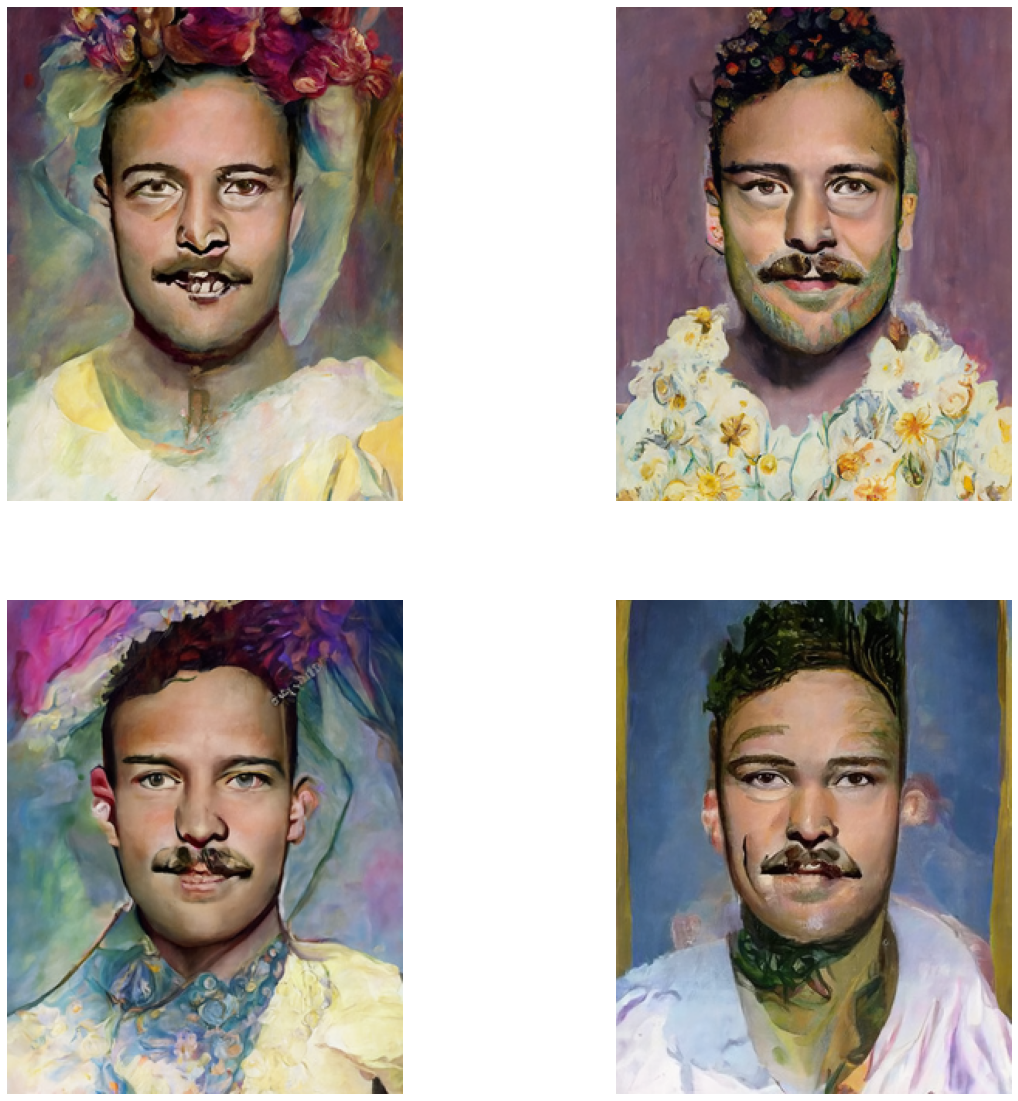

In [16]:
display_images(r);

In [14]:
torch.cuda.empty_cache()

  0%|          | 0/18 [00:00<?, ?it/s]

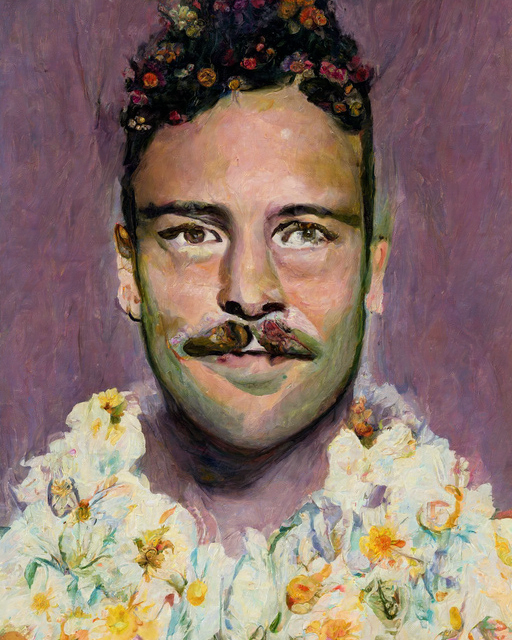

In [23]:
upscale.infer_apply((r[1], query))